# Extended Kalman Filter DSSE
The EKF method has two-steps i.e., prediction step and an update step. Note that the voltage magnitudes and voltage angles are the states to be estimated. Therefore, the number of states is twice as many compared to the total number of nodes in the system.

In [1]:
import os
import json
import math
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
ROOT = os.getcwd()
OUTPUTS = "outputs"

## Run OEDISI

In [2]:
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/gray/git/oedisi_dopf/scenario/
0 medium
1 medium_extreme
2 medium_high
3 small
4 ekf_small_medium
5 medium_medium
6 omoo_medium_extreme
7 omoo_medium
8 medium_low
9 ekf_ieee123
10 ieee123
11 lest_small
12 small_medium
13 omoo
14 omoo_small
15 small_low
16 small_high
17 lest_test
18 ieee123_update
19 lest_ieee123
20 small_extreme
21 large
22 ekf_medium_medium


In [5]:
index = 4
SCENARIO = SCENARIOS[index]
path = f"{SCENARIO_DIR}{SCENARIO}"
print(path)

/home/gray/git/oedisi_dopf/scenario/ekf_small_medium


In [6]:
print(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}")
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

oedisi build --system /home/gray/git/oedisi_dopf/scenario/ekf_small_medium/system.json --component-dict /home/gray/git/oedisi_dopf/scenario/ekf_small_medium/components.json --target-directory build_ekf_small_medium


sh: 1: oedisi: not found


32512

In [8]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")
print(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

oedisi run --runner build_ekf_small_medium/system_runner.json


sh: 1: oedisi: not found


## Load Outputs

In [9]:
directory = f"{OUTPUTS}/{SCENARIO}"
v_real = feather.read_feather(
    os.path.join(directory, "voltage_real.feather")
)
v_imag = feather.read_feather(
    os.path.join(directory, "voltage_imag.feather")
)
true_voltages = v_real.drop("time", axis=1) + 1j * v_imag.drop("time", axis=1)
true_voltages['time'] = pd.to_datetime(v_real['time'],format='%Y-%m-%d %H:%M:%S')
true_voltages.set_index('time', inplace=True)

v_mag = feather.read_feather(
    os.path.join(directory, "voltage_mag.feather")
)
v_angle = feather.read_feather(
    os.path.join(directory, "voltage_angle.feather")
)
v_rad = np.radians(v_angle.drop("time", axis=1).to_numpy())
estimated_voltages = v_mag.drop("time", axis=1) * np.exp(1j * v_rad)
estimated_voltages['time'] = pd.to_datetime(v_angle['time'],format='%Y-%m-%d %H:%M:%S')
estimated_voltages.set_index('time', inplace=True)

with open(os.path.join(directory, "topology.json")) as f:
    topology = Topology.parse_obj(json.load(f))
    base_voltage_df = pd.DataFrame(
        {
            "id": topology.base_voltage_magnitudes.ids,
            "value": topology.base_voltage_magnitudes.values,
        }	
    )
    base_voltage_df.set_index("id", inplace=True)
    base_voltages = base_voltage_df["value"]
    

## Plot: morning, noon, evening

In [10]:
def plot_ang(true, estimated, time, unit="rad"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.angle(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.angle(estimated.to_numpy()[0]), "-o")

    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    # ax.set_tick_params(axis='x', labelsize=5, rotation=-90)
    ax.set_xlabel("Node number")
    ax.set_ylabel("Voltage Angles")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Angles at t={time}")
    return fig

def plot_mag(true, estimated, time, unit="pu"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.abs(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.abs(estimated.to_numpy()[0]), "-o")
    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    ax.set_xlabel("Node number")
    ax.set_ylabel(f"Voltage Magnitudes ({unit})")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Magnitudes at t={time}")
    return fig


def errors(true_voltages, estimated_voltages):
    true_mag = np.abs(true_voltages)
    nonzero_parts = true_mag != 0.0
    MAPE = np.mean(
        np.array(np.abs(true_mag - np.abs(estimated_voltages)) / true_mag)[
            nonzero_parts
        ]
        * 100
    )
    angle_difference = np.abs(np.angle(true_voltages) - np.angle(estimated_voltages))
    angle_difference[angle_difference >= np.pi] = (
        2 * np.pi - angle_difference[angle_difference >= np.pi]
    )
    MAE = np.mean(np.array(angle_difference)[nonzero_parts] * 180 / np.pi)
    return MAPE, MAE


def error_table(true_voltages, estimated_voltages):
    error_table = []
    for i, t in enumerate(true_voltages.columns):
        MAPE, MAE = errors(true_voltages.iloc[:, i], estimated_voltages.iloc[:, i])
        error_table.append({"t": t, "MAPE": MAPE, "MAE": MAE})
    return pd.DataFrame(error_table)


def plot_errors(err_table):
    fig, ax = plt.subplots()
    ax.plot(err_table["t"], err_table["MAPE"])
    ax.plot(err_table["t"], err_table["MAE"])
    ax.legend(["MAPE (magnitudes)", "MAE (angles)"])
    ax.set_ylabel("Error")
    ax.set_xlabel("Time (15 minute)")
    ax.set_title("Voltage Errors")
    ax.set_xticks(err_table["t"][::5], err_table["t"][::5], rotation=-25, fontsize=5)
    return fig

### Morning

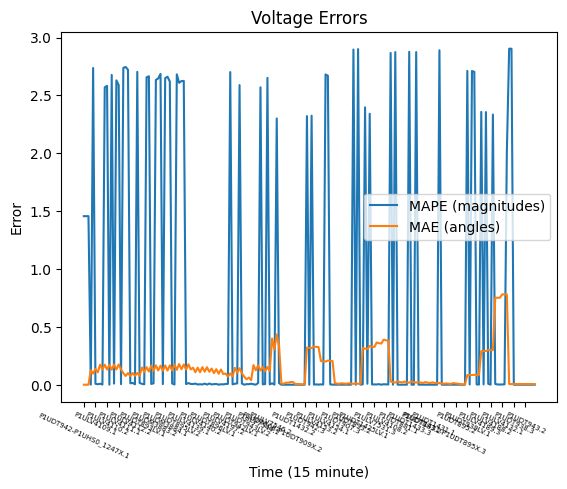

In [11]:
time='07:00'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_morning.png")

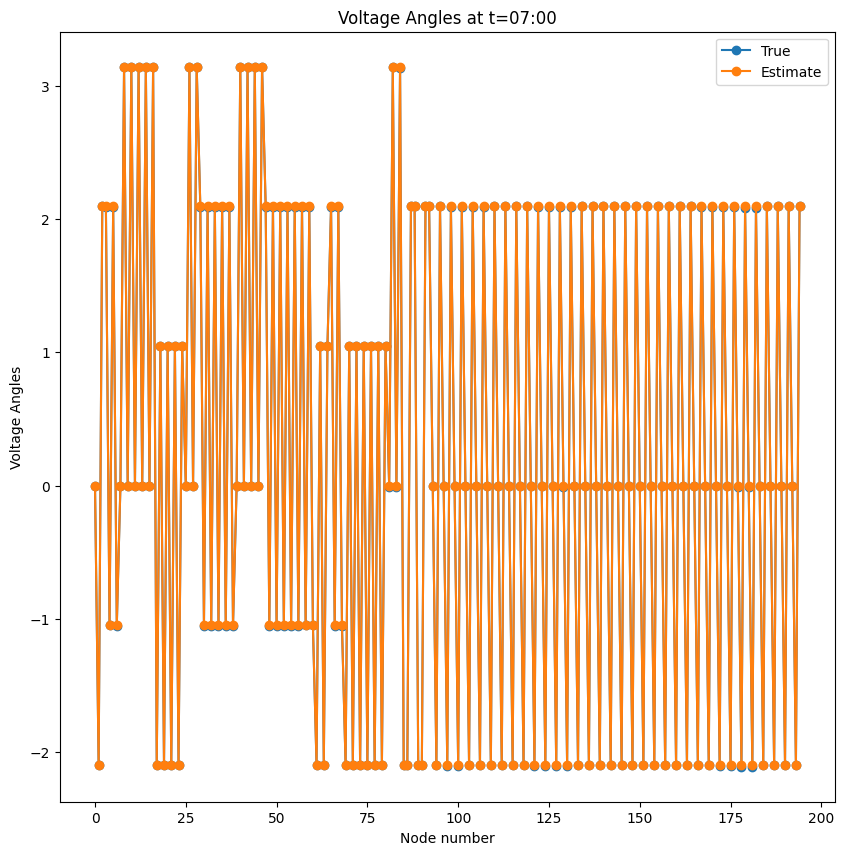

In [12]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_morning.png")

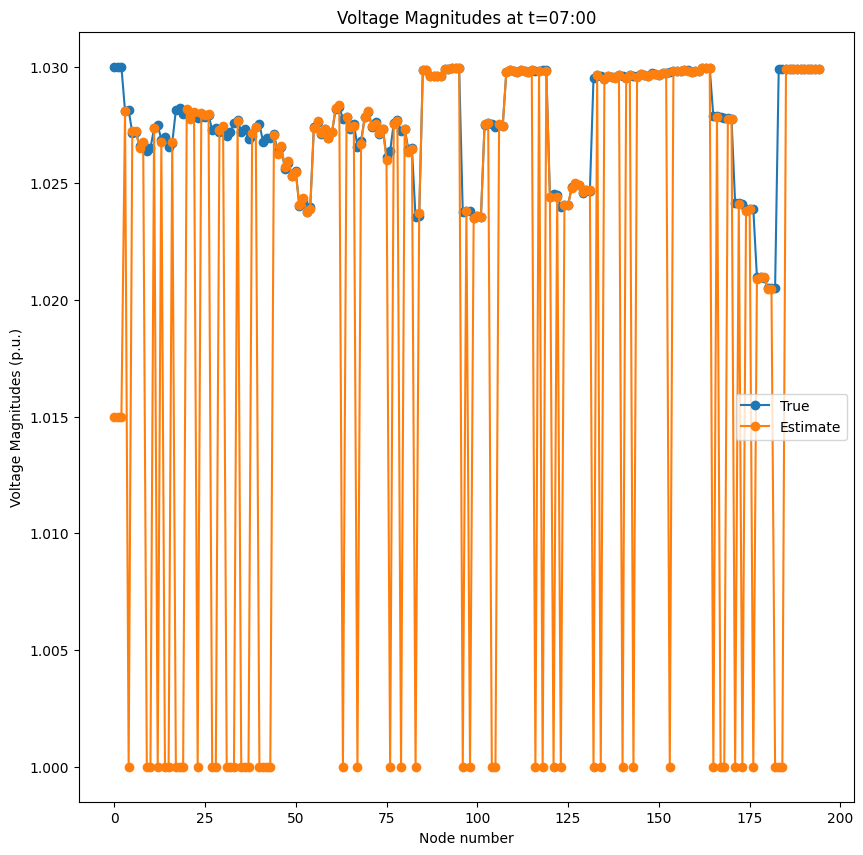

In [13]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_morning.png")

In [17]:
### Noon

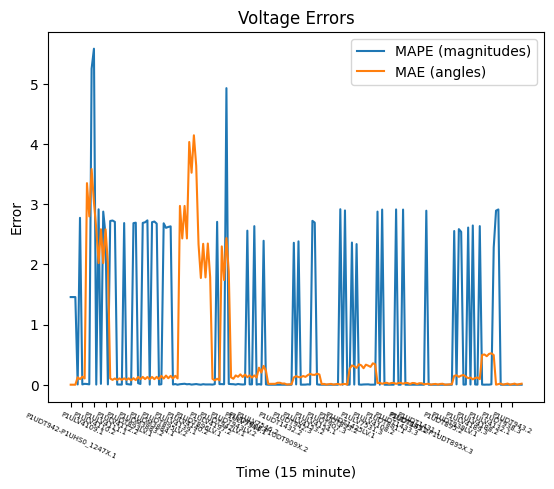

In [14]:
time='12:30'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_noon.png")

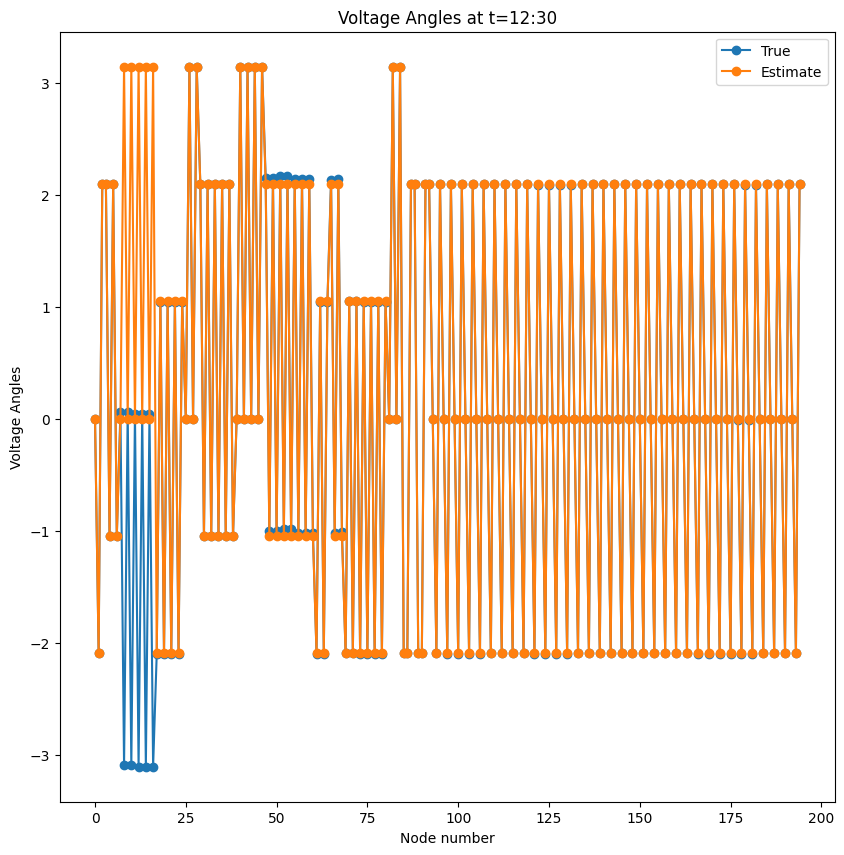

In [15]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_noon.png")

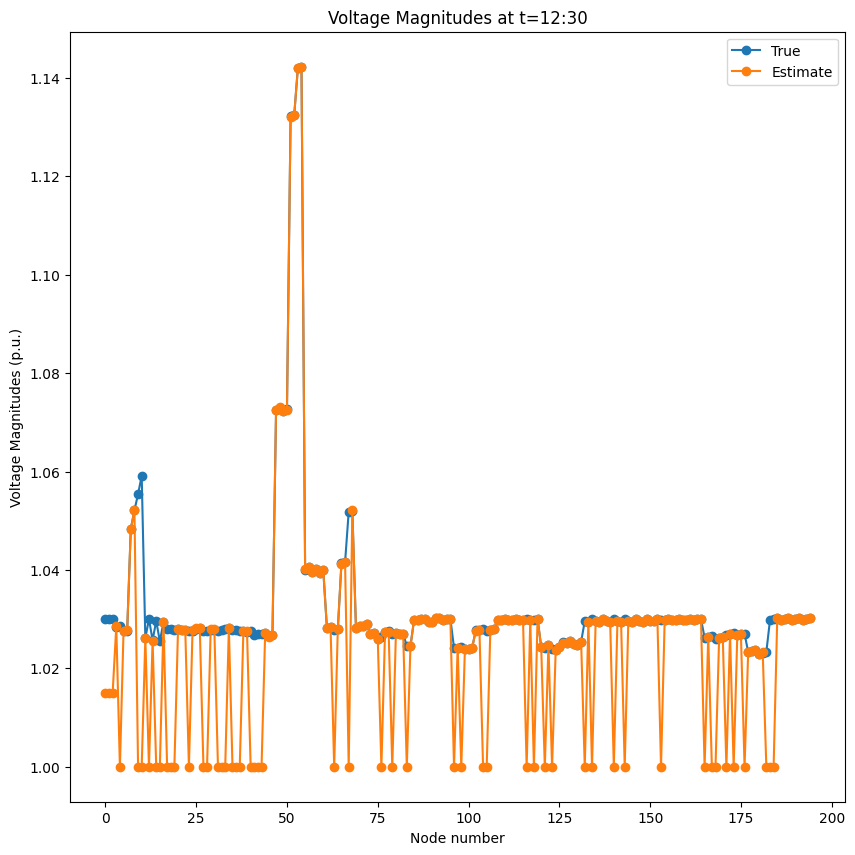

In [16]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_noon.png")

### Evening

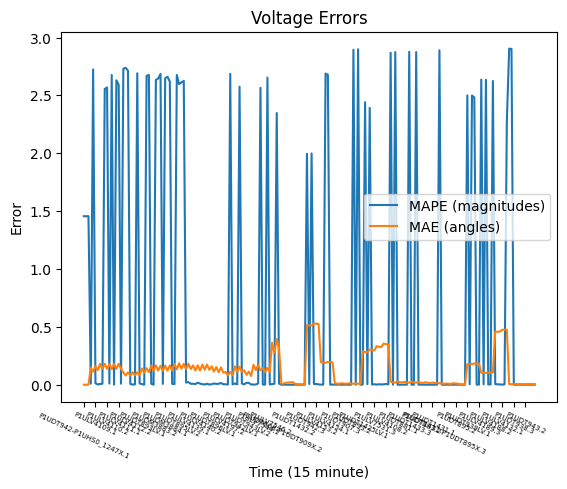

In [17]:
time='17:30'
true = true_voltages.at_time(time)
estimated = estimated_voltages.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_evening.png")

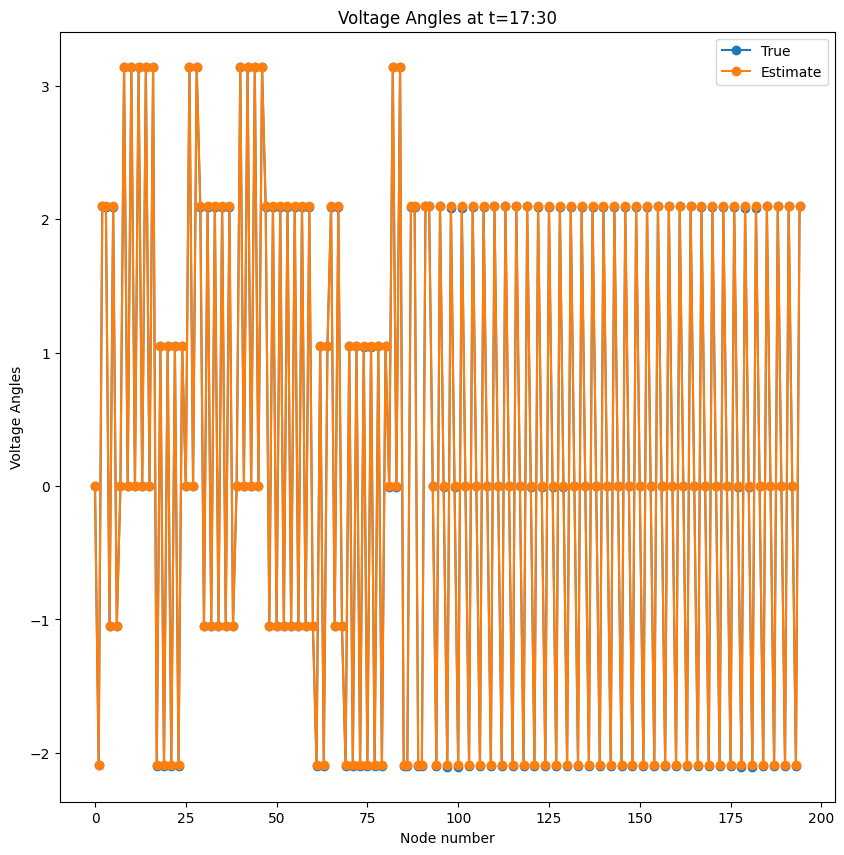

In [18]:
plot_ang(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/angle_evening.png")

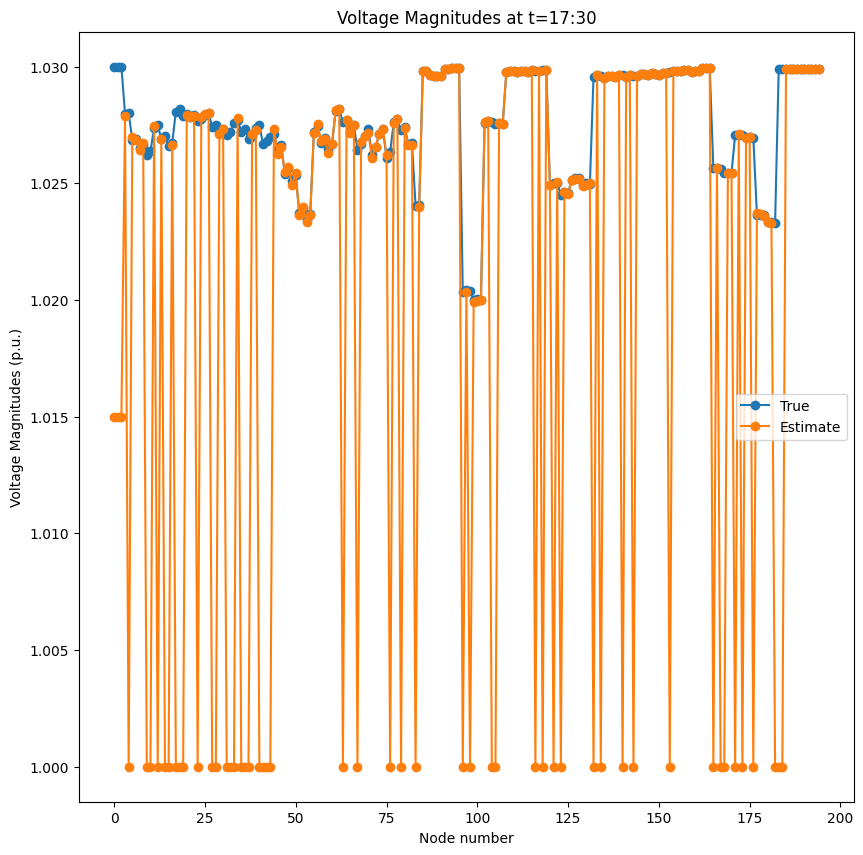

In [19]:
plot_mag(
    true / base_voltages,
    estimated / base_voltages,
    time=time,
    unit="p.u."
).savefig(f"{directory}/mag_evening.png")